In [8]:
!pip install noise pillow ipycanvas ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [78]:
import random
import uuid
import math
import _pickle as pkl

import noise
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from PIL import Image
from scipy.ndimage import gaussian_filter
from scipy import misc

import ipywidgets

In [10]:
from abc import ABC, abstractmethod

### Helper Functions

In [11]:
def hexToRGB(hexnum):
    if hexnum[0] == "#":
        hexnum = hexnum[1:]
        
    parsed = int('0x' + hexnum, base=16)
        
    return [(parsed >> 16) & 255, (parsed >> 8) & 255, parsed & 255]


def numpyToImage(array, filename):
    pass

def upscaleArray(array, scale):
    return np.cron(array, np.ones(scale, scale))

print(hexToRGB("#fafafa"))


[250, 250, 250]


## Stack and Layer Classes

The Stack class maintains a list of all Layer objects, and the arguments they call.  When invoked, the stack generates a numpy array based on the shape given to the stack during its initialization.

### Layer Class

The layer class accepts a numpy array, performs a transformation upon the array, then returns the transformed array

#### Usage
    TesselationLayer(array, kwargs**) -> modified array
    PerlinNoiseLayer(array, kwargs**) -> modified array

In [12]:
class Layer(np.ndarray):
    
    #TODO: need to add a seed component
    def __str__(self):
        return "{name}\narray: shape {array}".format(name=self.__class__.__name__, array=self.shape)
    
    def __json__(self):
        return {"name": self.__class__.__name__, "params": self.params}
    
    def __init__(self, array, **kwargs):
        pass
        #print("Initiated!")
        #self = self.apply(np.asarray(array), **kwargs).view(self.__class__)
    
    @classmethod
    def from_json(cls, json_obj):
        pass
    
    def __new__(cls, array, **kwargs):
        print("Creating new class")
    #    continue
        if kwargs:
            print("Kwargs found: {}".format(kwargs))
            cls.params = kwargs
        else:
            cls.params = cls.create_values(cls, cls.rand_param(cls))
        #    pass
            #cls.params = cls.create_values(cls.rand_param(cls))
        print("Params: ",cls.params)
        
        #TODO: apply self function here
        obj = cls.apply(cls, np.asarray(array), **cls.params).view(cls)
        return obj
    
    def randomizer(self, list_val):
        if isinstance(list_val[0], int):
            return random.randint(*list_val)
        elif isinstance(list_val[0], float):
            return random.uniform(*list_val)
            
    def create_values(self, values):
        return {k: self.randomizer(self, v) for k,v in values.items()}
    
    def update_parameters(self, values):
        """
            Update parameters of layer, and update underlying array.
            Parameters: values -> dict, dictionary of values to update, and the key of the value to update to.
            Returns: Class Layer -> return updated array value
        """
        for k, v in values.items():
            self.params[k] = v
        
        self = self.apply(np.asarray(self), **self.params).view(self.__class__)
        return self
    
    def rand_param(self):
        raise NotImplementedError("rand_param() must be implemented in new Layer class {}".format(self.__class__.__name__))
        
    def apply(self, array, **kwargs):
        raise NotImplementedError("apply() must be implemented in {}".format(self.__class__.__name__))

### Stack Class

The stack class contains a list of all layers, applies them to an array

#### Example usage
```
stack = ArtStack(np.zeros((512, 512)), stack=[(PerlinNoiselayer, {**kwargs}), (NormalizeLayer, {}), (ColorMapLayer, {map: map})])
stack.generate() -> returns array computed
stack.insert(Layer, position) -> Layer class is inserted into position

stack.get_layers() -> Returns list of layers w/parameters applied
```

#### Stack Class Serialization
If we want to save configurations to use for later, the Artstack class will contain a method to serialize the data + stack within it, and save it to a file as a json object.  Using pickle, we can use pickle.dumps to serialize the class as a byteclass, which can then be saved and loaded back from a json object.

In [13]:
class ArtStack():
    def __init__(self,shape, stack=None):
        self.shape = shape
        
        if stack:
            self.stack = stack
        else:
            self.stack = []
            
    @classmethod
    def from_filename(cls, filename):
        with open(filename) as stack_file:
            json_data = json.loads(stack_file)
            
    
    def _serialize(self):
        for layer_class, layer_params in zip(self.stack):
            #use pkl here
            pass
        return {
            "name": str(uuid.uuid4()),
            "layers": [layer.__json__ for layer in self.stack]
        }
            
    def append(self, layer_tuple):
        self.stack.append(layer_tuple)
            
    def generate(self):
        
        array = np.zeros(self.shape)
    
        for layer in self.stack:
            print(layer)
            array = self.apply(array, layer)
        
        return array
    
    def apply(self, array, layer_tuple):
        #print("Applying {layer} to {array} with {args}".format(layer=layer_tuple[0], array=array, args=layer_tuple[1]))
        return layer_tuple[0](array, **layer_tuple[1])
    
    def save(self, filename):
        pass

In [14]:
class FartStack(np.ndarray):
    def __new__(cls, size, stack):
        cls.stack = stack
        obj = np.zeros(size)
        
        for layer, params in stack:
            obj = layer.apply(cls, obj, **params).view(cls)
        
        return obj
        #return super().__new__(cls, *args, **kwargs)
            
        #return self.array
    @classmethod
    def from_file(cls, filename):
        pass
        
    def _serialize(self):
        pass

    def get(self):
        return self.array
    
    def thumbnail(self):
        pass
        
    def save(self, filename):
        pass

### Generator Class

The Generator class Allows us to create an ArtStack class using a series of Layers with either specified or unspecified parameters.

#### Usage
    generator = Generator(stack=[(PerlinNoiseLayer, {}), (GaussianFilter, {"sigma": 50}), ColorMapLayer, {})])
    stack = generator.generate((512, 512))
    
    #stack object is of ArtStack type, and contains all attributes associated
    type(stack) => class 'ArtStack'

In [15]:
class Generator:
    def __init__(self, stack=[]):
        if stack:
            self.stack = stack
        else:
            self.stack = []
    
    def append(self, layer):
        self.stack.append(layer)
        
    def insert(self, layer, position):
        pass
    
    def generate(self, size):
        """This function is hot garbage. Needs a rewrite."""
        #create array of size N
        array = np.zeros(size)
        #for layer in stack
        layer_list = []
        for layer_cls, layer_params in self.stack:
            print(layer_cls, layer_params)
        #    get parameters
            params = list(layer_cls.rand_param(layer_cls).keys())
            print(params)
            lyr_params = {}
            for parameter in params:
                if parameter in layer_params:
                    lyr_params[parameter] = layer_params[parameter]
                else:
                    #generate random parameter here
                    #Donald kunth, please forgive me
                    lyr_params[parameter] = layer_cls.randomizer(layer_cls, layer_cls.rand_param(layer_cls)[parameter])
                    
            layer_list.append((layer_cls, lyr_params))
            
        return FartStack(size, layer_list)

### Layers
List of Layers

Creating new class
Kwargs found: {'octaves': 9, 'scale': 1, 'persistence': 0.8, 'lacunarity': 3, 'base': 2}
Params:  {'octaves': 9, 'scale': 1, 'persistence': 0.8, 'lacunarity': 3, 'base': 2}
9
PerlinNoiseLayer
array: shape (512, 512)


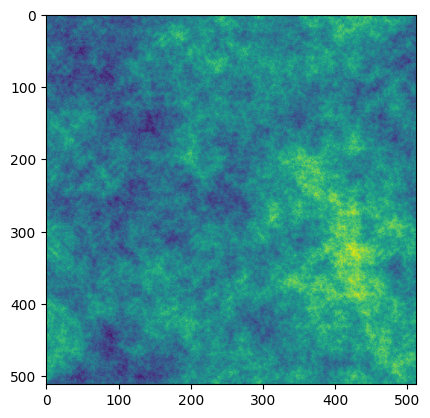

In [16]:
class PerlinNoiseLayer(Layer):
    
    def rand_param(self):
        return {
            "scale": [1, 1],
            "octaves": [2,10],
            "persistence": [0.0, 1.0],
            "lacunarity": [3, 9],
            "base" : [1, 300]
        }
            
    def apply(self, array, octaves=8, scale=1, persistence=0.8, lacunarity=3, base=2):
        print(octaves)
        x_idx = np.linspace(0, 1, array.shape[0])
        y_idx = np.linspace(0, 1, array.shape[1])
        
        world_x, world_y = np.meshgrid(x_idx, y_idx)
        
        return np.vectorize(noise.pnoise2)(world_x/scale,
                                           world_y/scale,
                                           octaves=octaves,
                                           persistence=persistence,
                                           lacunarity=lacunarity,
                                           repeatx=1/scale,
                                           repeaty=1/scale,
                                           base=base)
    
array = np.zeros((512, 512))
rand_layer = PerlinNoiseLayer(array, octaves=9, scale=1, persistence=0.8, lacunarity=3, base=2)
print(rand_layer)
#rand_layer = PerlinNoiseLayer()
#test = PerlinNoiseLayer(array)
plt.imshow(rand_layer)

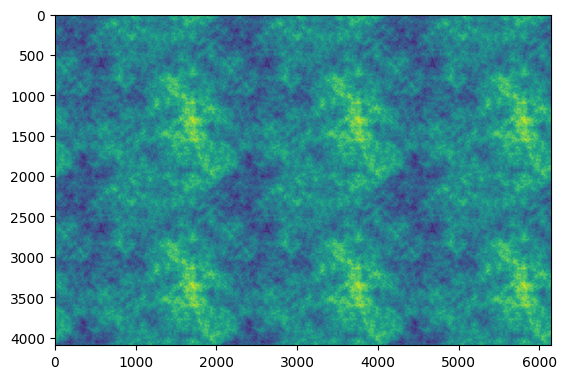

In [17]:
tiled = np.tile(rand_layer, (2,3))
scaled_tile = np.kron(rand_layer, np.ones((4,4)))

scaled_tiled = np.tile(scaled_tile, (2,3))
plt.imshow(scaled_tiled)

Creating new class
Params:  {}
NormalizeLayer
array: shape (4096, 6144)
NormalizeLayer
array: shape ()
NormalizeLayer
array: shape ()


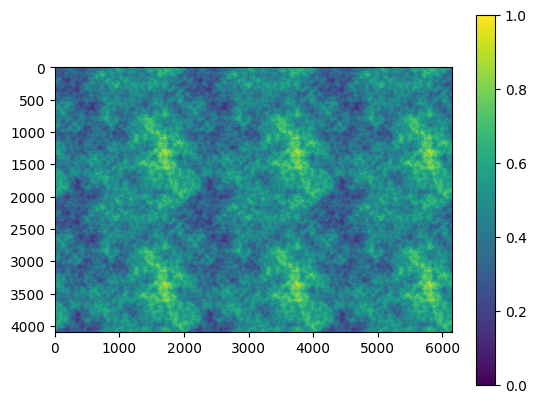

In [18]:
class NormalizeLayer(Layer):
    
    def rand_param(self):
        return {}
    
    def apply(self, array):
        return (array - np.min(array))/ (np.max(array) - np.min(array))
    
normalize_layer = NormalizeLayer(scaled_tiled)
print(normalize_layer)
print(np.max(normalize_layer))
print(np.min(normalize_layer))

plt.imshow(normalize_layer)
plt.colorbar()

Creating new class
Kwargs found: {'sigma': 75}
Params:  {'sigma': 75}
Sigma value: 75
Creating new class
Params:  {'sigma': 8}
Sigma value: 8
GaussianFilter
array: shape (4096, 6144)


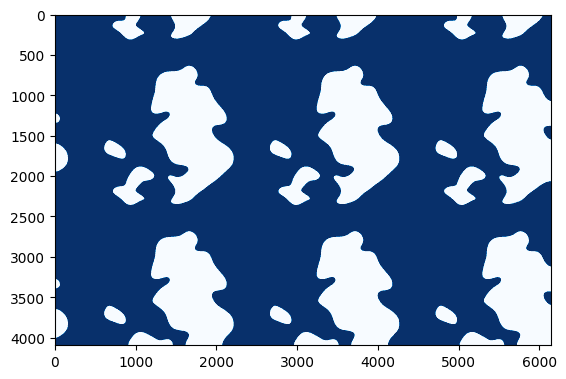

In [19]:
class GaussianFilter(Layer):
    def rand_param(self):
        return {
            "sigma": [2, 15]
        }
    def apply(self, array, sigma=75):
        print("Sigma value: {}".format(sigma))
        return gaussian_filter(array, sigma)

g_layer = GaussianFilter(normalize_layer, sigma=75)
plt.imshow(np.where(g_layer > 0.5, 0, 1), cmap=plt.cm.get_cmap('Blues', 6))

g = GaussianFilter
print(g(normalize_layer))

Creating new class
Params:  {}
Creating new class
Kwargs found: {'colormap': [(0, [38, 70, 83]), (0.25, [42, 157, 143]), (0.45, [233, 196, 106]), (0.7, [231, 111, 81])]}
Params:  {'colormap': [(0, [38, 70, 83]), (0.25, [42, 157, 143]), (0.45, [233, 196, 106]), (0.7, [231, 111, 81])]}


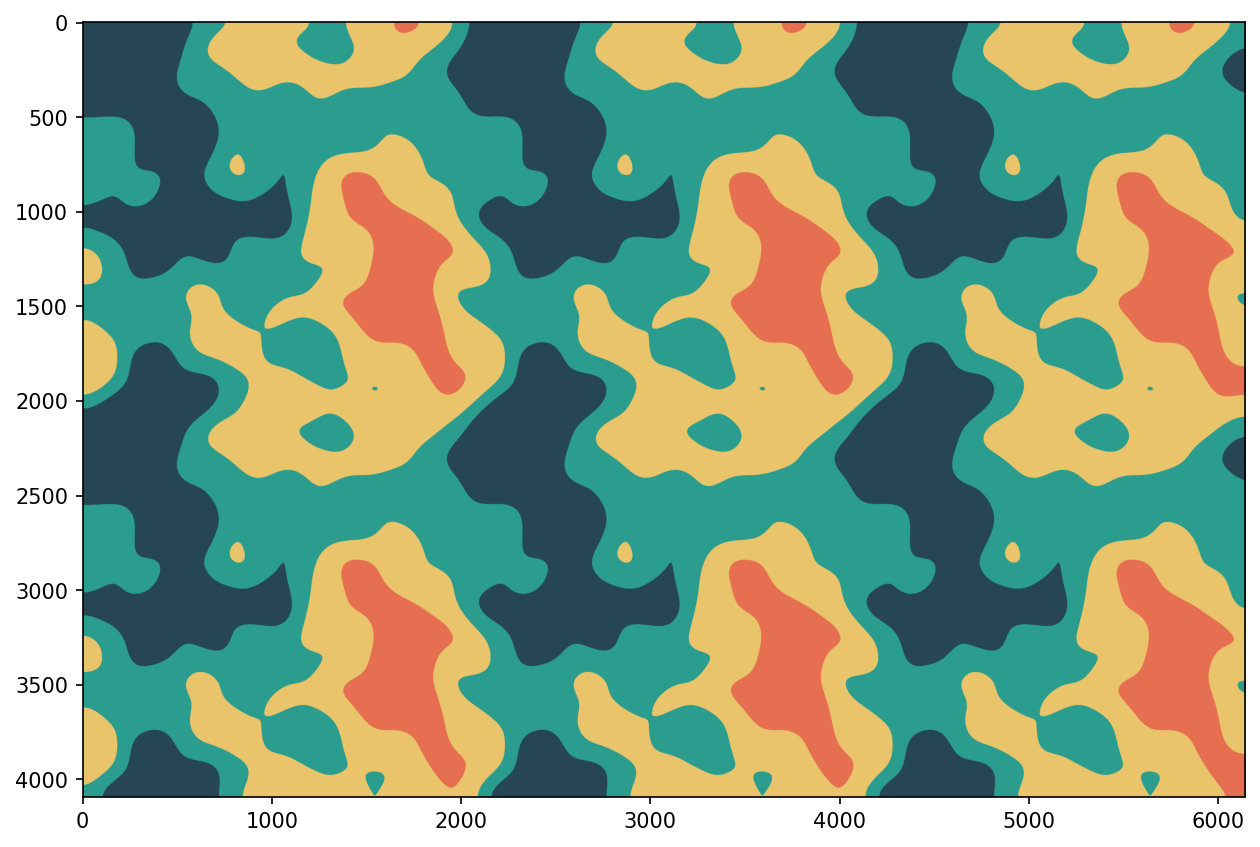

In [20]:
class ColorMapTransform(Layer):
    
    def randomize_params(self):
        #can't do randomize yet
        return {
            colormap: []
        }
    
    def apply(self, array, colormap=map):
        
        color_array = np.zeros((array.shape[0], array.shape[1], 3))
        
        #using colormap and np.where,
        for value, color in self.params["colormap"]:
            subset = np.where(array > value)
            color_array[subset] = color
            
        return color_array
    
map = [
    (0, [38, 70, 83]),
    (0.25, [42, 157, 143]),
    (0.45, [233, 196, 106]),
    (0.70, [231, 111, 81]),
]

rainbow_map = [
    (0, [255, 173, 173]),
    (0.125, [255, 214, 165]),
    (0.25, [253, 255, 182]),
    (0.375, [202, 255, 191]),
    (0.5, [155, 246, 255]),
    (0.625, [160, 196, 255]),
    (0.750, [189, 178, 255]),
    (0.825, [255, 198, 255])
]

#norm_layer=  NormalizeLayer()
f = ColorMapTransform(NormalizeLayer(g_layer), colormap=map)

figure(figsize=(10,12), dpi=150)
plt.imshow(f.astype(np.uint8))
#plt.savefig("tny_color.png")
#plt.imshow(np.tile(f.astype(np.uint8)))
#Image.fromarray(f.astype(np.uint8)).show()

In [21]:
class ColorDB():
    def __len__(self):
        return len(self.colors)
    
    def __getitem__(self, index):
        return self.colors[index]
    
    def __init__(self, filename):
        self.colors = []
        with open(filename, 'rb') as color_file:
            while True:
                try:
                    self.colors.append(pkl.load(color_file))
                except:
                    break
            print("Colors found: ", len(self.colors))
    

In [22]:
class ColorMapLayer(Layer):
    def rand_param(self):
        return {
            "index": [0,1000]
        }
    
    def apply(self, array, colordb=None, index=1):
        
        color_map = colordb[index]
        step = int(100 / len(color_map))
        color_map = [(0 + ((step / 100) * i), list(color_map[i])) for i in range(len(color_map))]
        print(color_map)
        color_array = np.zeros((array.shape[0], array.shape[1], 3))
        
        #using colormap and np.where,
        for value, color in color_map:
            subset = np.where(array > value)
            color_array[subset] = color
            
        return color_array

Creating new class
Params:  {}
Colors found:  1016
Creating new class
Kwargs found: {'colordb': <__main__.ColorDB object at 0x7f24a0316bf0>, 'index': 1}
Params:  {'colordb': <__main__.ColorDB object at 0x7f24a0316bf0>, 'index': 1}
[(0.0, [188, 195, 187]), (0.25, [31, 61, 17]), (0.5, [96, 126, 53]), (0.75, [81, 71, 42])]


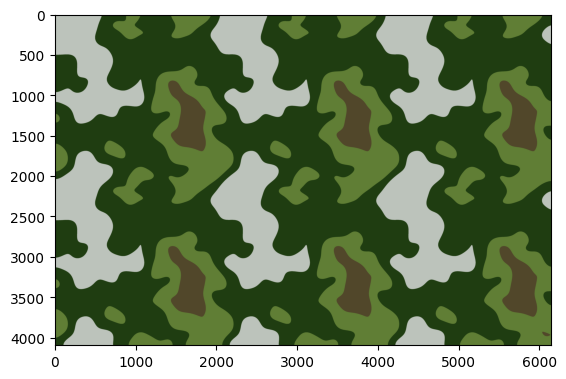

In [23]:
cmap = ColorMapLayer(NormalizeLayer(g_layer), colordb=ColorDB("colors_1000.pkl"), index=1) 
plt.imshow(cmap.astype(np.uint8))

In [24]:
class TiledLayer(Layer):
    def rand_param(self):
        return {
            "shape": (1,2)
        }
    
    def apply(self, array, shape=(2,3)):
        return np.tile(array, shape)

Colors found:  1016
(<class '__main__.PerlinNoiseLayer'>, {'scale': 1.5, 'octaves': 2, 'persistence': 0.948445635677, 'lacunarity': 3, 'base': 58})
Creating new class
Kwargs found: {'scale': 1.5, 'octaves': 2, 'persistence': 0.948445635677, 'lacunarity': 3, 'base': 58}
Params:  {'scale': 1.5, 'octaves': 2, 'persistence': 0.948445635677, 'lacunarity': 3, 'base': 58}
2
(<class '__main__.NormalizeLayer'>, {})
Creating new class
Params:  {}
(<class '__main__.ColorMapLayer'>, {'colordb': <__main__.ColorDB object at 0x7f247f28ff10>, 'index': 36})
Creating new class
Kwargs found: {'colordb': <__main__.ColorDB object at 0x7f247f28ff10>, 'index': 36}
Params:  {'colordb': <__main__.ColorDB object at 0x7f247f28ff10>, 'index': 36}
[(0.0, [22, 20, 27]), (0.2, [83, 70, 84]), (0.4, [176, 169, 202]), (0.6000000000000001, [113, 108, 152]), (0.8, [132, 132, 174])]
ColorMapLayer
array: shape (10000, 10000, 3)


AttributeError: scipy.misc is deprecated and has no attribute imsave.

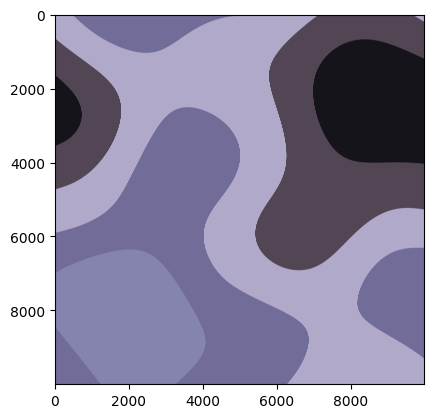

In [79]:
#stack = ArtStack(array.shape, stack=[(PerlinNoiseLayer, {'scale': 2, 'octaves': 2, 'persistence': 0.9484456356772994, 'lacunarity': 4, 'base': 58}), (TiledLayer, {"shape": (2,3)}), (NormalizeLayer, {}), (ColorMapLayer, {"colordb": ColorDB("colors_1000.pkl"), "index": 550})])
stack = ArtStack((10000,10000), stack=[(PerlinNoiseLayer, {'scale': 1.5, 'octaves': 2, 'persistence': 0.948445635677, 'lacunarity': 3, 'base': 58}), (NormalizeLayer, {}), (ColorMapLayer, {"colordb": ColorDB("colors_1000.pkl"), "index": 36})])

new_array = stack.generate()
print(new_array)
plt.imshow(new_array.astype(np.uint8))
#print(json.dumps(stack.__dict__))
#print(PerlinNoiseLayer.__name__)
misc.imsave('purple_dream.png', new_array)

In [106]:
print(new_array.shape)
im = Image.fromarray(np.uint8(new_array), 'RGB')
#im = Image.fromarray((new_array * 255).astype(np.uint8))
im.save("purple_dream.png")

#im.display()
#Image.fromarray(np.asarray(new_array))
#im.save("purple_dream.png")
#im = Image.fromarray(new_array)
#im.save("purple_dream.png")
#g = Generator([(PerlinNoiseLayer, {}), (GaussianFilter, {"sigma": 10})])
#f = g.generate((512, 512))
#plt.imshow(f)

(10000, 10000, 3)


In [27]:
print(f.stack)

[(<class '__main__.PerlinNoiseLayer'>, {'scale': 1, 'octaves': 3, 'persistence': 0.046283025269005296, 'lacunarity': 9, 'base': 288}), (<class '__main__.GaussianFilter'>, {'sigma': 10})]


# Ignore past this

In [28]:
plt.imshow(world)
plt.colorbar()

NameError: name 'world' is not defined

In [ ]:
x = np.linspace(-2*np.pi, 2*np.pi, 512)
print(x.shape)
x_array = np.tile(np.sin(2*x), (512,1))
print(x_array.shape)

In [ ]:
x_array.shape
plt.imshow(x_array)

In [ ]:
double = x_array * x_array.T
plt.imshow(double)

In [ ]:
test = world * double
plt.imshow(test)

In [ ]:
radial_x = np.linspace(1,-1,512)[:, None]
radial_y = np.linspace(1,-1,512)[None,:]

arr = np.sqrt(radial_x ** 2 + radial_y **2)

In [ ]:
plt.imshow(arr)

In [ ]:
radial = world * arr
plt.imshow(radial)
plt.colorbar()

In [ ]:
from ipycanvas import Canvas, hold_canvas
import random

In [ ]:
c = Canvas(height=512, width=512)
c.put_image_data(radial)

In [ ]:
height = 700
width = 900
size = 2000

num_lines = 85

density = int(size / num_lines)

print("Density: {}".format(density))
print("Number of lines: {}".format(num_lines))

In [ ]:
canvas = Canvas(width=1000, height=1000, sync_image_data=True)
canvas.line_join = "bevel"
canvas.miter_limit = 0
canvas.line_cap = "round"
canvas.line_width = 15
canvas.fill_style = "#040404"
canvas.fill_rect(0,0,1000)

def draw_line(row, col):
    lower_left = [
        (col * size/density) - size/2,
        (row * size/density) - size/2
    ]
    
    upper_right = [
        ((col + 1) * size/density) - size/2,
        ((row + 1) * size/density) - size/2
    ]
    
    lower_right = [
        ((col + 1) * size/density) - size/2,
        (row * size/density) - size/2
    ]
    
    upper_left = [
        (col * size/density) - size/2,
        ((row + 1) * size/density) - size/2
    ]
    
    res = random.randint(0,3)
    
    color = random.randint(0,2)
    
    
    if (color == 0):
        canvas.stroke_style = "#4fd6ae"
    elif (color == 1):
        canvas.stroke_style = "#f87666"
    elif (color == 2):
        canvas.stroke_style = "#8d80ad"
    
    #canvas.stroke_line(upper_left[0], upper_left[1], lower_right[0], lower_right[1])
    if (res == 0):
        #canvas.stroke_line(lower_left[0], lower_left[1], upper_right[0], upper_right[1])
        canvas.stroke_line(upper_left[0], upper_left[1], lower_right[0], lower_right[1])
    else:
        #canvas.stroke_line(upper_left[0], upper_left[1], lower_right[0], lower_right[1])
        canvas.stroke_line(lower_left[0], lower_left[1], upper_right[0], upper_right[1])
    #t.setposition(lower_left[0], lower_left[1])
    #t.pendown()
    #t.setposition(upper_right[0], upper_right[1])
    #t.penup()

with hold_canvas(canvas):
    for row in range( density):
        for col in range( density ):
            draw_line(row, col)
        
display(canvas)

In [ ]:
#canvas.to_file("techno23.png")